# Mini-ensemble analysis template
* last update: 8-July-2020
* Daniel Kennedy (djk2120@ucar.edu)
* works best with latest version of ncar_pylib
    * which has xarray version 15.1
    * you probably need at least version 12.2

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import cartopy.crs as ccrs
%matplotlib inline

In [2]:
xr.show_versions()


INSTALLED VERSIONS
------------------
commit: None
python: 3.7.5 (default, Dec 10 2019, 14:55:39) 
[GCC 8.3.0]
python-bits: 64
OS: Linux
OS-release: 3.10.0-1127.13.1.el7.x86_64
machine: x86_64
processor: x86_64
byteorder: little
LC_ALL: en_US.UTF-8
LANG: en_US.UTF-8
LOCALE: en_US.UTF-8
libhdf5: 1.10.5
libnetcdf: 4.7.3

xarray: 0.15.1
pandas: 1.0.3
numpy: 1.18.2
scipy: 1.3.2
netCDF4: 1.5.3
pydap: installed
h5netcdf: None
h5py: 2.10.0
Nio: 1.5.5
zarr: 2.4.0
cftime: 1.1.2
nc_time_axis: None
PseudoNetCDF: None
rasterio: 1.1.3
cfgrib: None
iris: 2.4.0
bottleneck: 1.3.2
dask: 2.14.0
distributed: 2.14.0
matplotlib: 3.2.1
cartopy: 0.18.0b2
seaborn: 0.10.0
numbagg: None
setuptools: 46.1.3
pip: 20.1.1
conda: None
pytest: 5.4.1
IPython: 7.13.0
sphinx: 3.0.2


## Optional: add extra workers
* not really necessary here, I don't think

In [2]:
#for use on Casper
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
cluster = SLURMCluster(cores=18,
                     processes=18, memory="190GB",
                     project='P93300641',
                     walltime='3:00:00')
cluster.scale(18)
client = Client(cluster)

In [2]:
#for use on cheyenne
from dask_jobqueue import PBSCluster
from dask.distributed import Client
cluster = PBSCluster(cores=36,
                     processes=36, memory="109GB",
                     project='P93300041',
                     queue='regular',
                     resource_spec='select=1:ncpus=36:mem=109G',
                     walltime='02:00:00')
cluster.scale(36)
client = Client(cluster)

In [3]:
client

Client Scheduler: tcp://10.12.205.30:32892 Dashboard: http://10.12.205.30:8787/status,Cluster Workers: 18 Cores: 18 Memory: 190.08 GB


## Read in the data

In [4]:
# define some info for the ensemble 
ens = range(33)
thedir = '/glade/scratch/djk2120/mini_ens/output/'
paths = [thedir+'miniens_oaat'+str(ee).zfill(4)+'_h1.nc' for ee in ens]
pftnames = ['BG','NEMT','NEBT','NDBT','BETT','BEMT','BDTT','BDMT','BDBT','BES',
            'BDMS','BDBS','C3ArG','C3G','C4G','C3C']
pftindex={}
for i,v in zip(range(16),pftnames):
    pftindex[v]=i

In [5]:
%%time 
# grab only FPSN and TLAI from all the ensemble members
#    note that this is PFT level output
# YOU SHOULD ADD parallel='True' running with extra workers
ens_vars = ['FPSN','TLAI']
def preprocess(ds):
    return ds[ens_vars]
ds = xr.open_mfdataset(paths,combine='nested',concat_dim='ens',decode_cf=False,
                       preprocess=preprocess,parallel='True')
ds['ens']=ens

CPU times: user 181 ms, sys: 18.7 ms, total: 199 ms
Wall time: 1.31 s


In [6]:
# grab just one copy of the various extra variables
extra_vars = xr.open_dataset(paths[0],decode_cf=False)
for v in extra_vars.data_vars:
    if v not in ens_vars:
        ds[v]=extra_vars[v]
ds['pft']=ds['pfts1d_itype_veg'] #reassign pft variable for easier analysis

In [7]:
# redefine the time dimension
#    xarray not very good at interpreting CESM time fields
time_vector = cftime.num2date(ds['time'].values-16,units=ds['time'].attrs['units'],
                calendar=ds['time'].attrs['calendar'])
ds['time']=xr.DataArray(time_vector,attrs=ds['time'].attrs)

## Some analysis examples


### Where are the needleleaf temperate tree gridcells?

In [8]:
ixpft = ds['pfts1d_itype_veg']==pftindex['NEMT']
lats = ds['pfts1d_lat'][ixpft]
lons = ds['pfts1d_lon'][ixpft]
lons[lons>180]=lons[lons>180]-360  #needed to match cartopy

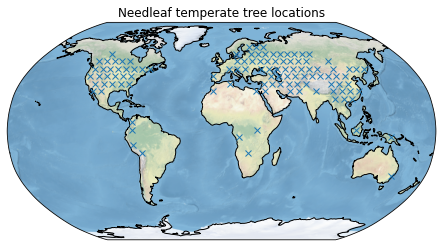

In [9]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
ax.set_global()
ax.stock_img()
ax.coastlines()
ax.plot(lons, lats, 'x', transform=ccrs.PlateCarree())
plt.title('Needleaf temperate tree locations');

### MAX LAI for broadleaf evergreen tropical trees
- preserving gridcell information

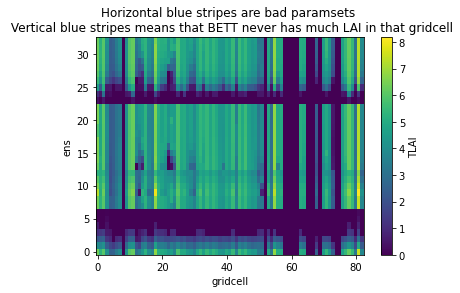

In [10]:
ixpft = ds['pfts1d_itype_veg']==pftindex['BETT']
ds['TLAI'].isel(pft=ixpft).max(axis=1).plot() #take the max along the time-axis
plt.xlabel('gridcell')
plt.title('Horizontal blue stripes are bad paramsets \n Vertical blue stripes means that BETT never has much LAI in that gridcell');

### MAX LAI across PFTs
- take the max and then average across gridcells

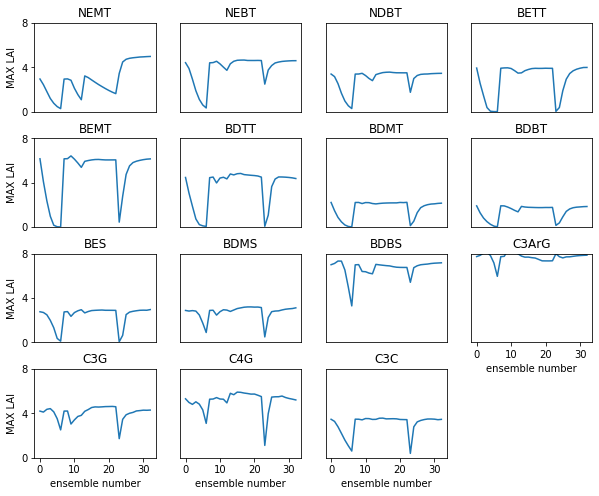

In [8]:
plt.figure(figsize=[10,8])
for i in 1+np.arange(15):  #loop through the 15 pfts

    #analysis bits
    ixpft = ds['pfts1d_itype_veg']==i
    maxlai = ds['TLAI'].isel(pft=ixpft).max(axis=1).mean(axis=1)
    
    #plotting
    plt.subplot(4,4,i)
    plt.plot(maxlai)
    if (i==1)|(i==5)|(i==9)|(i==13):
        plt.ylabel('MAX LAI')
        plt.yticks([0,4,8])
    else:
        plt.yticks([])
    if i>11:
        plt.xlabel('ensemble number')
    else:
        plt.xticks([])
    plt.title(pftnames[i])
    plt.ylim([0,8])
    
plt.subplots_adjust(hspace=0.3)

### AVG FPSN across PFTs
- averaged across gridcells

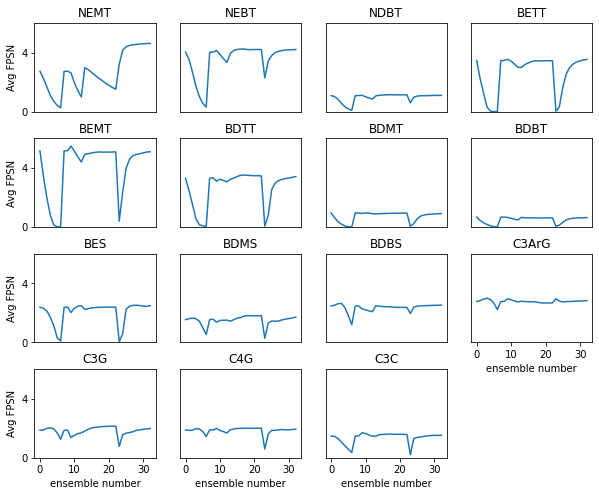

In [9]:
plt.figure(figsize=[10,8])
for i in 1+np.arange(15):  #loop through the 15 pfts

    #analysis bits
    ixpft   = ds['pfts1d_itype_veg']==i
    avgfpsn = ds['TLAI'].isel(pft=ixpft).groupby('ens').mean(dim=xr.ALL_DIMS)
    
    #plotting
    plt.subplot(4,4,i)
    plt.plot(ds['ens'],avgfpsn)
    if (i==1)|(i==5)|(i==9)|(i==13):
        plt.ylabel('Avg FPSN')
        plt.yticks([0,4,8])
    else:
        plt.yticks([])
    if i>11:
        plt.xlabel('ensemble number')
    else:
        plt.xticks([])
    plt.title(pftnames[i])
    plt.ylim([0,6])
    
plt.subplots_adjust(hspace=0.3)

In [10]:
npixels = (ds['TLAI'].sel(ens=0).max(axis=0)>0.1).groupby('pft').sum()
ee = 1
survival = np.zeros([15,32])
for i,ee in zip(range(len(ens[1:])),ens[1:]):
    survival[:,i] = 100*((ds['TLAI'].sel(ens=ee).max(axis=0)>0.1).groupby('pft').sum()
                         /npixels)[1:16]

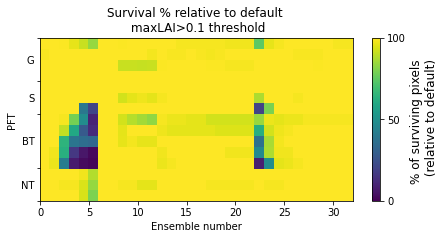

In [11]:
fig,ax = plt.subplots(figsize=[7,3])
plt.pcolormesh(survival,vmin=0,vmax=100)
cbar=plt.colorbar(ticks=[0,50,100])
plt.title('Survival % relative to default \n maxLAI>0.1 threshold')
plt.yticks([0,3,8,11,15])
ax.set_yticks([1.5,5.5,9.5,13], minor=True)
ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.set_yticklabels(['NT','BT','S','G'],minor=True)
for tick in ax.yaxis.get_minor_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)
plt.ylabel('PFT')
plt.xlabel('Ensemble number');
cbar.set_label('% of surviving pixels \n (relative to default)',fontsize=12)

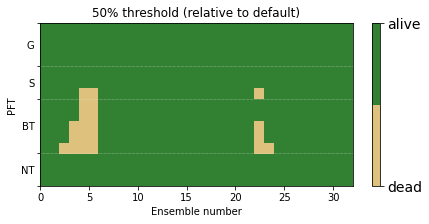

In [12]:
vals = np.ones([2,4])
vals[0,:3]=np.array([223,194,125])/256
vals[1,:3]=np.array([50,130,50])/256
newcmp = matplotlib.colors.ListedColormap(vals)

thresh = 50
alive = survival>thresh
fig,ax = plt.subplots(figsize=[7,3])
plt.pcolormesh(alive,cmap=newcmp)

cbar=plt.colorbar(ticks=[0, 1])
cbar.ax.set_yticklabels(['dead', 'alive']) 
cbar.ax.tick_params(labelsize=14) 
plt.yticks([0,3,8,11,15])
ax.set_yticks([1.5,5.5,9.5,13], minor=True)
for y in [3,8,11]:
    plt.plot([0,32],[y,y],':',color=[0.9,0.9,0.9],linewidth=0.5)

ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.set_yticklabels(['NT','BT','S','G'],minor=True)
for tick in ax.yaxis.get_minor_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)
plt.title('50% threshold (relative to default)')
plt.ylabel('PFT')
plt.xlabel('Ensemble number');

### Gridcell output
* (contains more variables)
* note that this likewise has collapsed spatial dimension

In [13]:
gridpaths = paths = [thedir+'miniens_oaat'+str(ee).zfill(4)+'_h0.nc' for ee in ens]
ds_grid = xr.open_mfdataset(gridpaths,combine='nested',concat_dim='ens',
                       decode_cf=False,parallel='True')
ds_grid['ens']=ens
time_vector = cftime.num2date(ds_grid['time'].values-16,
                              units=ds_grid['time'].attrs['units'],
                              calendar=ds_grid['time'].attrs['calendar'])
ds_grid['time']=xr.DataArray(time_vector,dims='time',attrs=ds_grid['time'].attrs)

In [14]:
pinfo = pd.DataFrame()
pinfo['nens']=[6,2,4,10,10]
pinfo['name']=['kmax','hksat_adjustfactor','medlynslope',
               'rootprof_beta','krmax']
pinfo['ix0']=[1,7,9,13,23]
pinfo

,nens,name,ix0
0,6,kmax,1
1,2,hksat_adjustfactor,7
2,4,medlynslope,9
3,10,rootprof_beta,13
4,10,krmax,23


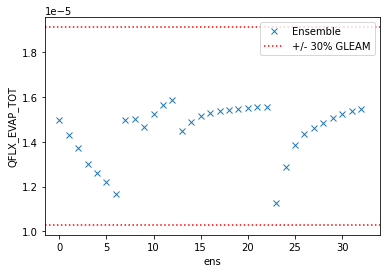

In [15]:
ds_grid['QFLX_EVAP_TOT'].mean(axis=[1,2]).plot.line('x')
obs = 1.47e-5 #mm/d
plt.plot([-1.5,40],[obs+0.3*obs,obs+0.3*obs],'r:')
plt.plot([-1.5,40],[obs-0.3*obs,obs-0.3*obs],'r:')
plt.xlim([-1.5,34])
plt.legend(['Ensemble','+/- 30% GLEAM']);

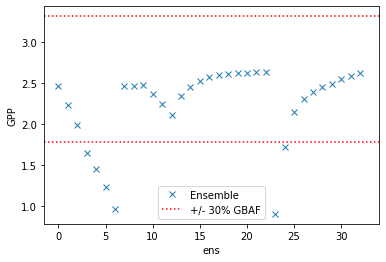

In [16]:
(24*60*60*ds_grid['GPP']).mean(axis=[1,2]).plot.line('x')
obs = 2.55 #gC/m2/d
plt.plot([-1.5,40],[obs+0.3*obs,obs+0.3*obs],'r:')
plt.plot([-1.5,40],[obs-0.3*obs,obs-0.3*obs],'r:')
plt.xlim([-1.5,34])
plt.legend(['Ensemble','+/- 30% GBAF']);

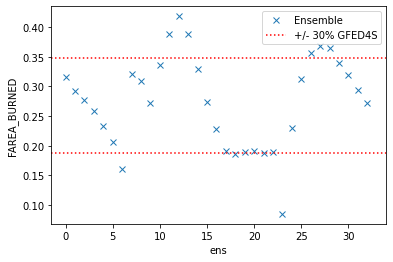

In [17]:
mdays = np.tile(np.array([31,28,31,30,31,30,31,31,30,31,30,31]),30)
obs = 0.268 # %/month
(24*60*60*100*mdays*ds_grid['FAREA_BURNED'].mean(axis=2)).mean(axis=1).plot.line('x')
plt.plot([-1.5,40],[obs+0.3*obs,obs+0.3*obs],'r:')
plt.plot([-1.5,40],[obs-0.3*obs,obs-0.3*obs],'r:')
plt.xlim([-1.5,34])
plt.legend(['Ensemble','+/- 30% GFED4S']);

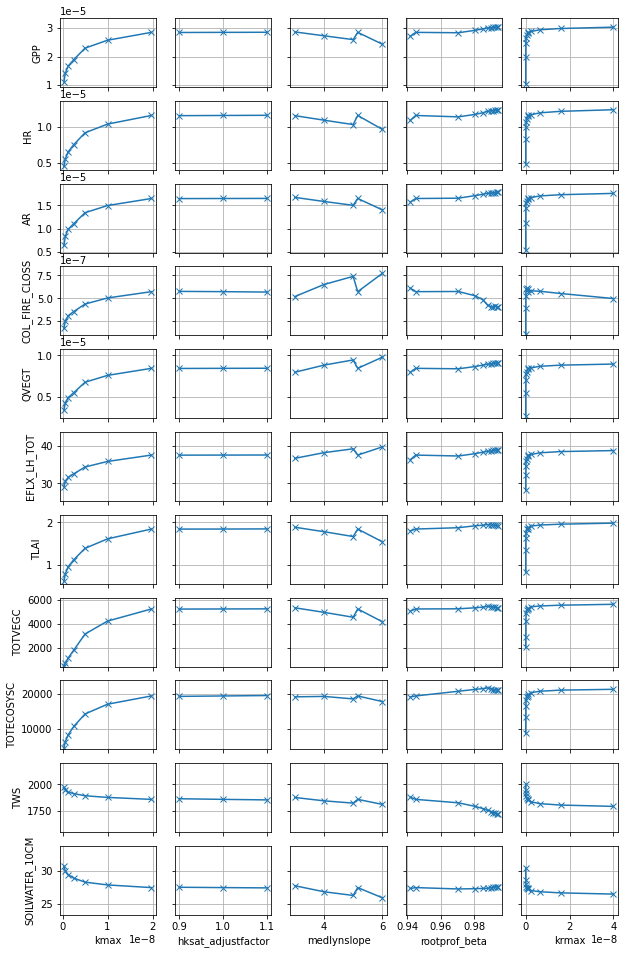

In [21]:
somevars = ['GPP','HR','AR','COL_FIRE_CLOSS','QVEGT','EFLX_LH_TOT',
           'TLAI','TOTVEGC','TOTECOSYSC','TWS','SOILWATER_10CM']
nvars = len(somevars)

plt.figure(figsize=[10,1.5*nvars])

for j,thisvar in zip(range(nvars),somevars):

    y = ds_grid[thisvar].mean(axis=[1,2]).values
    ylims = [np.min(y)-0.1*abs(np.min(y)),np.max(y)+0.1*abs(np.max(y))]

    for i in range(5):

        name = pinfo['name'][i]
        ix0  = pinfo['ix0'][i]
        nens = pinfo['nens'][i]
        ixp  = [0]+list(ix0+np.arange(nens))

        out = ds_grid[thisvar].mean(axis=[1,2])[ixp].values
        x   = params[name][ixp].values
        ixs = np.argsort(x)

        plt.subplot(nvars,5,5*j+i+1)
        plt.plot(x[ixs],out[ixs],'-x')
        
        plt.ylim(ylims)
        plt.grid()

        if (i==0):
            plt.ylabel(thisvar)
        else:
            frame1 = plt.gca()
            frame1.axes.yaxis.set_ticklabels([])
        if (j==(nvars-1)):
            plt.xlabel(name)
        else:
            frame1 = plt.gca()
            frame1.axes.xaxis.set_ticklabels([])

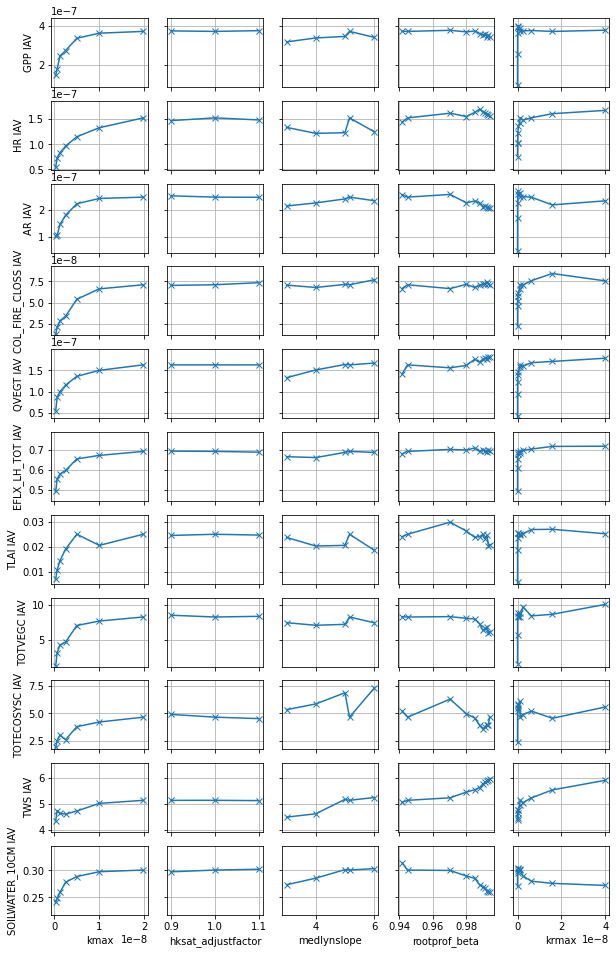

In [22]:
somevars = ['GPP','HR','AR','COL_FIRE_CLOSS','QVEGT','EFLX_LH_TOT',
           'TLAI','TOTVEGC','TOTECOSYSC','TWS','SOILWATER_10CM']
nvars = len(somevars)

plt.figure(figsize=[10,1.5*nvars])

for j,thisvar in zip(range(nvars),somevars):
    iav = ds_grid[thisvar].mean(axis=2).groupby('time.year').mean(dim='time').std(dim='year').values
    ylims = [np.min(iav)-0.1*abs(np.min(iav)),np.max(iav)+0.1*abs(np.max(iav))]
    for i in range(5):

        name = pinfo['name'][i]
        ix0  = pinfo['ix0'][i]
        nens = pinfo['nens'][i]
        ixp  = [0]+list(ix0+np.arange(nens))

        out = iav[ixp]
        x   = params[name][ixp].values
        ixs = np.argsort(x)

        plt.subplot(nvars,5,5*j+i+1)
        plt.plot(x[ixs],out[ixs],'-x')
        plt.ylim(ylims)
        plt.grid()

        if (i==0):
            plt.ylabel(thisvar+' IAV')
        else:
            frame1 = plt.gca()
            frame1.axes.yaxis.set_ticklabels([])
        if (j==(nvars-1)):
            plt.xlabel(name)
        else:
            frame1 = plt.gca()
            frame1.axes.xaxis.set_ticklabels([])
    


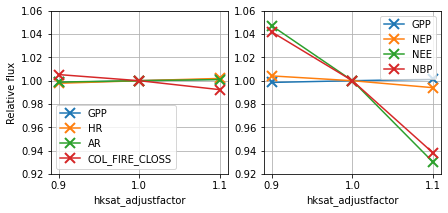

In [124]:
somevars = ['GPP','HR','AR','COL_FIRE_CLOSS']
i=1

plt.figure(figsize=[7,3])

name = pinfo['name'][i]
ix0  = pinfo['ix0'][i]
nens = pinfo['nens'][i]
ixp  = [0]+list(ix0+np.arange(nens))
plt.subplot(121)
for thisvar in somevars:
    x = params[name].values[ixp]
    ixs = np.argsort(x)
    out = ds_grid[thisvar].mean(axis=[1,2]).values[ixp]
    plt.plot(x[ixs],out[ixs]/out[0],'-x',markersize=10,mew=2)
plt.legend(somevars)
plt.ylabel('Relative flux')
plt.xlabel(name);
plt.ylim([0.92,1.06])
plt.grid()
plt.xticks([0.9,1,1.1])

somevars = ['GPP','NEP','NEE','NBP']
plt.subplot(122)
for thisvar in somevars:
    x = params[name].values[ixp]
    ixs = np.argsort(x)
    out = ds_grid[thisvar].mean(axis=[1,2]).values[ixp]
    plt.plot(x[ixs],out[ixs]/out[0],'-x',markersize=10,mew=2)
plt.legend(somevars)
plt.xlabel(name);
plt.ylim([0.92,1.06])
plt.xticks([0.9,1,1.1])
plt.grid()

### If you want the param values
* safe to average across segment/variants for kmax and rpb
* might also consider averaging across PFTS 1-15 if you want a single value
* varying params provided in paramlist
    * ['medlynslope', 'kmax', 'hksat_adjustfactor', 'krmax', 'rootprof_beta']

In [20]:
pdir = '/glade/scratch/djk2120/mini_ens/paramfiles/'
parampaths = sorted(glob.glob(pdir+'*.nc'))
params = xr.open_mfdataset(parampaths,combine='nested',concat_dim='ens',parallel='True')
params['ens']=ens
params['kmax']          = params['kmax'].mean(axis=[1,2])
params['medlynslope']   = params['medlynslope'].mean(axis=1)
params['krmax']         = params['krmax'].mean(axis=1)
params['rootprof_beta'] = params['rootprof_beta'].mean(axis=[1,2])
paramlist = ['medlynslope', 'kmax', 'hksat_adjustfactor', 'krmax', 'rootprof_beta']

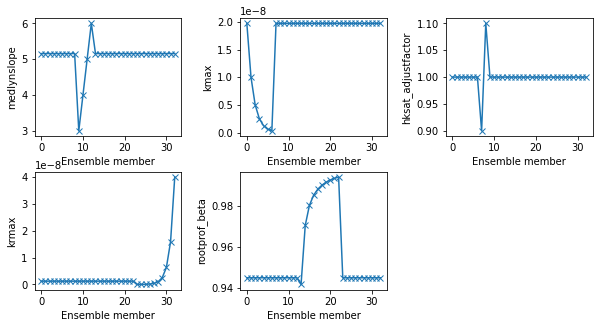

In [240]:
i=0
plt.figure(figsize=[10,5])
for p in paramlist:
    if len(params[p].values.shape)>1:
        param_single_value = params[p].mean(axis=1)
    else:
        param_single_value = params[p]
    i = i+1
    plt.subplot(2,3,i)
    plt.plot(ens,param_single_value,'-x')
    plt.xlabel('Ensemble member')
    plt.ylabel(p);
plt.subplots_adjust(hspace=0.3,wspace=0.4)